# Tweets about Covid-19 vaccines

In [1]:
# Import packages
import nltk
from pprint import pprint
import yaml
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import neattext as ntx
from wordcloud import WordCloud

## Part 1: EDA on during2_covidTweets_v2

In [2]:
data = pd.read_csv('data/during2_covidTweets_v2.csv')
data.head()

datetime             tweet_id  \
0  2022-03-30 23:59:43+00:00  1509319493717213185   
1  2022-03-30 23:59:18+00:00  1509319387941113856   
2  2022-03-30 23:57:25+00:00  1509318912940261381   
3  2022-03-30 23:56:36+00:00  1509318706509213699   
4  2022-03-30 23:52:42+00:00  1509317728632393729   

                                                text        username  \
0  @cryptotosis @SputnikNetwork @cryptotosis 5sta...  TheWadSquad_io   
1                     @Eon_Reel @POTUS COVID is real   sharonlafon91   
2  Staff COVID-19 cases continue to stymie small-...         JDignum   
3  Staff COVID-19 cases continue to stymie small-...         JDignum   
4  COVID elbows Jets in face - Winnipeg Free Pres...         JDignum   

                                                 url  \
0  https://twitter.com/TheWadSquad_io/status/1509...   
1  https://twitter.com/sharonlafon91/status/15093...   
2  https://twitter.com/JDignum/status/15093189129...   
3  https://twitter.com/JDignum/status/15093187065...   
4  https://twitter.com/JDignum/status/15093177286...   

               user_location  like_count  retweet_count  follower_count  \
0                   Stargaze           1              0            3062   
1                        NaN           3              0             107   
2  Hellberta🔥via Twitterstan           0              0            2478   
3  Hellberta🔥via Twitterstan           0              0            2478   
4  Hellberta🔥via Twitterstan           0              0            2478   

   reply_count  verified     hashtags  
0            1     False  ['sputnik']  
1            3     False          NaN  
2            0     False          NaN  
3            0     False          NaN  
4            0     False          NaN

In [3]:
data.shape

(86093, 12)

In [4]:
data.isnull().sum()

datetime              0
tweet_id              0
text                  0
username              0
url                   0
user_location     22577
like_count            0
retweet_count         0
follower_count        0
reply_count           0
verified              0
hashtags          75230
dtype: int64

### Simple visualisation (E.g Visualizing Tweet count vs Location)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'In Your Mind Now'),
  Text(1, 0, 'http://www.zyite.com/'),
  Text(2, 0, 'United States'),
  Text(3, 0, 'Los Angeles, CA'),
  Text(4, 0, 'Around the world'),
  Text(5, 0, 'USA'),
  Text(6, 0, 'London'),
  Text(7, 0, 'Bangladesh'),
  Text(8, 0, 'Orange County, CA'),
  Text(9, 0, 'Global'),
  Text(10, 0, 'Toronto, Ontario'),
  Text(11, 0, 'the deep south.'),
  Text(12, 0, 'California, USA'),
  Text(13, 0, 'Colorado, USA'),
  Text(14, 0, 'Chicago, IL'),
  Text(15, 0, 'Singapore'),
  Text(16, 0, 'Vancouver, British Columbia'),
  Text(17, 0, 'India'),
  Text(18, 0, '8 Spadina Ave, Toronto, Canada'),
  Text(19, 0, 'NC')])

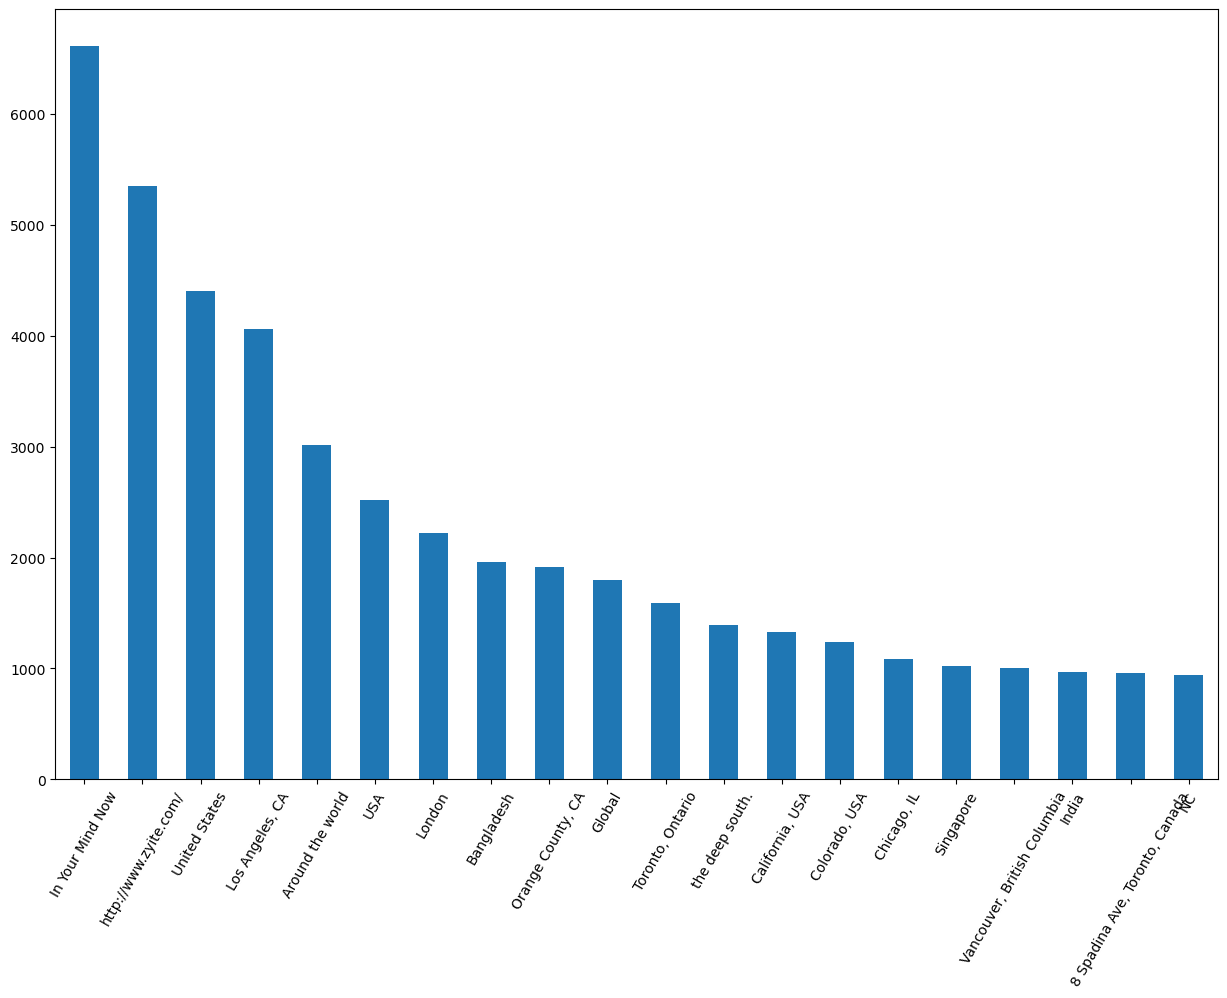

In [5]:
plt.figure(figsize=(15,10))
data['user_location'].value_counts().nlargest(20).plot(kind='bar')
plt.xticks(rotation=60)

### Word cloud in general (What do ppl talk about - Most frequent words or top keywords) 

(-0.5, 999.5, 499.5, -0.5)

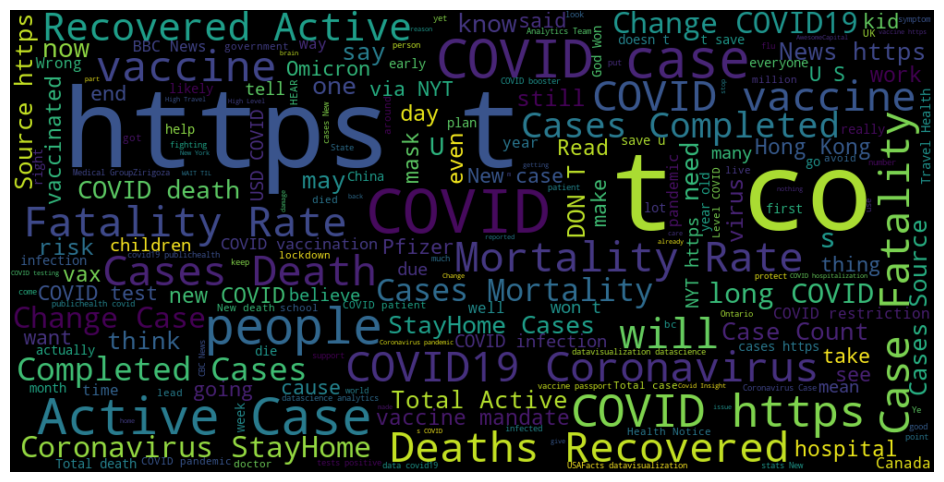

In [6]:
words = ' '.join([word for word in data['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

### Check for duplicate tweets based on the tweet content

In [7]:
duplicate_tweets = data[data.duplicated(['text'])]
print('Number of duplicate tweets:', len(duplicate_tweets))

Number of duplicate tweets: 5852


### Drop duplicate tweets

In [8]:
data = data.drop_duplicates('text')
data.shape

(80241, 12)

### <font color=#FF0000>**Sentiment Analysis (using Textblob)**</font> <br>
**Polarity:** 1 means positive statement, -1 means a negative statement and 0 means neutral.
<br>
**Subjectivity:** Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is a float which lies in the range of [0,1].

### Clean the data using neattext library

In [9]:
data['clean_data'] = data['text'].apply(ntx.remove_hashtags)
data['clean_data'] = data['clean_data'].apply(ntx.remove_urls)
data['clean_data'] = data['clean_data'].apply(ntx.remove_userhandles)
data['clean_data'] = data['clean_data'].apply(ntx.remove_multiple_spaces)
data['clean_data'] = data['clean_data'].apply(ntx.remove_special_characters)

In [10]:
data['clean_data']

0                                                  5stars 
1                                            COVID is real
2        Staff COVID19 cases continue to stymie smallbu...
3        Staff COVID19 cases continue to stymie smallbu...
4        COVID elbows Jets in face  Winnipeg Free Press...
                               ...                        
86088     People in hospital are often quite ill andor ...
86089     Thank you Yes there is considerable concern a...
86090    Anaheim Union High School District COVID Case ...
86091    Capistrano USD COVID Case Count as of 0010 on ...
86092     Oh absolutely Not saying Quebec is a poster c...
Name: clean_data, Length: 80241, dtype: object

In [11]:
data.shape

(80241, 13)

### Using stopwords to remove words that are generally considered to be of little value 

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [13]:
stop_words = stopwords.words('english')   
len(stop_words)

179

In [14]:
def stopWords(tweet):
    clean_tweet = tweet
    clean_tweet = " ".join(word for word in clean_tweet.split() if word not in stop_words)
    return clean_tweet

In [15]:
data['clean_data'] = data['clean_data'].apply(lambda x: stopWords(x))

In [16]:
data.head()

datetime             tweet_id  \
0  2022-03-30 23:59:43+00:00  1509319493717213185   
1  2022-03-30 23:59:18+00:00  1509319387941113856   
2  2022-03-30 23:57:25+00:00  1509318912940261381   
3  2022-03-30 23:56:36+00:00  1509318706509213699   
4  2022-03-30 23:52:42+00:00  1509317728632393729   

                                                text        username  \
0  @cryptotosis @SputnikNetwork @cryptotosis 5sta...  TheWadSquad_io   
1                     @Eon_Reel @POTUS COVID is real   sharonlafon91   
2  Staff COVID-19 cases continue to stymie small-...         JDignum   
3  Staff COVID-19 cases continue to stymie small-...         JDignum   
4  COVID elbows Jets in face - Winnipeg Free Pres...         JDignum   

                                                 url  \
0  https://twitter.com/TheWadSquad_io/status/1509...   
1  https://twitter.com/sharonlafon91/status/15093...   
2  https://twitter.com/JDignum/status/15093189129...   
3  https://twitter.com/JDignum/status/15093187065...   
4  https://twitter.com/JDignum/status/15093177286...   

               user_location  like_count  retweet_count  follower_count  \
0                   Stargaze           1              0            3062   
1                        NaN           3              0             107   
2  Hellberta🔥via Twitterstan           0              0            2478   
3  Hellberta🔥via Twitterstan           0              0            2478   
4  Hellberta🔥via Twitterstan           0              0            2478   

   reply_count  verified     hashtags  \
0            1     False  ['sputnik']   
1            3     False          NaN   
2            0     False          NaN   
3            0     False          NaN   
4            0     False          NaN   

                                          clean_data  
0                                             5stars  
1                                         COVID real  
2  Staff COVID19 cases continue stymie smallbusin...  
3  Staff COVID19 cases continue stymie smallbusin...  
4  COVID elbows Jets face Winnipeg Free Press COV...

### Assigning Polarity and Subjectivity to the Tweets using Textblob

In [17]:
from textblob import TextBlob

# Function to assign polarity and subjectivity to the tweets
def blob_fun(text):
    senti = TextBlob(text)
    senti_polarity = senti.sentiment.polarity
    senti_subjectivity = senti.sentiment.subjectivity
    
    if senti_polarity > 0:
        res = 'Positive'
    elif senti_polarity < 0:
        res = 'Negative'
    elif senti_polarity == 0:
        res ="Neutral"
        
    result = {'polarity':senti_polarity,'subjectivity':senti_subjectivity,'sentiment':res}
    
    return result

In [18]:
data['results'] = data['clean_data'].apply(lambda x: blob_fun(x))

In [19]:
data.head()

datetime             tweet_id  \
0  2022-03-30 23:59:43+00:00  1509319493717213185   
1  2022-03-30 23:59:18+00:00  1509319387941113856   
2  2022-03-30 23:57:25+00:00  1509318912940261381   
3  2022-03-30 23:56:36+00:00  1509318706509213699   
4  2022-03-30 23:52:42+00:00  1509317728632393729   

                                                text        username  \
0  @cryptotosis @SputnikNetwork @cryptotosis 5sta...  TheWadSquad_io   
1                     @Eon_Reel @POTUS COVID is real   sharonlafon91   
2  Staff COVID-19 cases continue to stymie small-...         JDignum   
3  Staff COVID-19 cases continue to stymie small-...         JDignum   
4  COVID elbows Jets in face - Winnipeg Free Pres...         JDignum   

                                                 url  \
0  https://twitter.com/TheWadSquad_io/status/1509...   
1  https://twitter.com/sharonlafon91/status/15093...   
2  https://twitter.com/JDignum/status/15093189129...   
3  https://twitter.com/JDignum/status/15093187065...   
4  https://twitter.com/JDignum/status/15093177286...   

               user_location  like_count  retweet_count  follower_count  \
0                   Stargaze           1              0            3062   
1                        NaN           3              0             107   
2  Hellberta🔥via Twitterstan           0              0            2478   
3  Hellberta🔥via Twitterstan           0              0            2478   
4  Hellberta🔥via Twitterstan           0              0            2478   

   reply_count  verified     hashtags  \
0            1     False  ['sputnik']   
1            3     False          NaN   
2            0     False          NaN   
3            0     False          NaN   
4            0     False          NaN   

                                          clean_data  \
0                                             5stars   
1                                         COVID real   
2  Staff COVID19 cases continue stymie smallbusin...   
3  Staff COVID19 cases continue stymie smallbusin...   
4  COVID elbows Jets face Winnipeg Free Press COV...   

                                             results  
0  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...  
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...  
2  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...  
3  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...  
4  {'polarity': 0.19999999999999998, 'subjectivit...

In [20]:
data.shape

(80241, 14)

In [21]:
data = data.join(pd.json_normalize(data = data['results']))

In [22]:
data.head()

datetime             tweet_id  \
0  2022-03-30 23:59:43+00:00  1509319493717213185   
1  2022-03-30 23:59:18+00:00  1509319387941113856   
2  2022-03-30 23:57:25+00:00  1509318912940261381   
3  2022-03-30 23:56:36+00:00  1509318706509213699   
4  2022-03-30 23:52:42+00:00  1509317728632393729   

                                                text        username  \
0  @cryptotosis @SputnikNetwork @cryptotosis 5sta...  TheWadSquad_io   
1                     @Eon_Reel @POTUS COVID is real   sharonlafon91   
2  Staff COVID-19 cases continue to stymie small-...         JDignum   
3  Staff COVID-19 cases continue to stymie small-...         JDignum   
4  COVID elbows Jets in face - Winnipeg Free Pres...         JDignum   

                                                 url  \
0  https://twitter.com/TheWadSquad_io/status/1509...   
1  https://twitter.com/sharonlafon91/status/15093...   
2  https://twitter.com/JDignum/status/15093189129...   
3  https://twitter.com/JDignum/status/15093187065...   
4  https://twitter.com/JDignum/status/15093177286...   

               user_location  like_count  retweet_count  follower_count  \
0                   Stargaze           1              0            3062   
1                        NaN           3              0             107   
2  Hellberta🔥via Twitterstan           0              0            2478   
3  Hellberta🔥via Twitterstan           0              0            2478   
4  Hellberta🔥via Twitterstan           0              0            2478   

   reply_count  verified     hashtags  \
0            1     False  ['sputnik']   
1            3     False          NaN   
2            0     False          NaN   
3            0     False          NaN   
4            0     False          NaN   

                                          clean_data  \
0                                             5stars   
1                                         COVID real   
2  Staff COVID19 cases continue stymie smallbusin...   
3  Staff COVID19 cases continue stymie smallbusin...   
4  COVID elbows Jets face Winnipeg Free Press COV...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...       0.0           0.0   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...       0.2           0.3   
2  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
3  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
4  {'polarity': 0.19999999999999998, 'subjectivit...       0.2           0.5   

  sentiment  
0   Neutral  
1  Positive  
2  Positive  
3  Positive  
4  Positive

In [23]:
data.rename(columns={'sentiment': 'Textblob'}, inplace=True)

In [24]:
data.head()

datetime             tweet_id  \
0  2022-03-30 23:59:43+00:00  1509319493717213185   
1  2022-03-30 23:59:18+00:00  1509319387941113856   
2  2022-03-30 23:57:25+00:00  1509318912940261381   
3  2022-03-30 23:56:36+00:00  1509318706509213699   
4  2022-03-30 23:52:42+00:00  1509317728632393729   

                                                text        username  \
0  @cryptotosis @SputnikNetwork @cryptotosis 5sta...  TheWadSquad_io   
1                     @Eon_Reel @POTUS COVID is real   sharonlafon91   
2  Staff COVID-19 cases continue to stymie small-...         JDignum   
3  Staff COVID-19 cases continue to stymie small-...         JDignum   
4  COVID elbows Jets in face - Winnipeg Free Pres...         JDignum   

                                                 url  \
0  https://twitter.com/TheWadSquad_io/status/1509...   
1  https://twitter.com/sharonlafon91/status/15093...   
2  https://twitter.com/JDignum/status/15093189129...   
3  https://twitter.com/JDignum/status/15093187065...   
4  https://twitter.com/JDignum/status/15093177286...   

               user_location  like_count  retweet_count  follower_count  \
0                   Stargaze           1              0            3062   
1                        NaN           3              0             107   
2  Hellberta🔥via Twitterstan           0              0            2478   
3  Hellberta🔥via Twitterstan           0              0            2478   
4  Hellberta🔥via Twitterstan           0              0            2478   

   reply_count  verified     hashtags  \
0            1     False  ['sputnik']   
1            3     False          NaN   
2            0     False          NaN   
3            0     False          NaN   
4            0     False          NaN   

                                          clean_data  \
0                                             5stars   
1                                         COVID real   
2  Staff COVID19 cases continue stymie smallbusin...   
3  Staff COVID19 cases continue stymie smallbusin...   
4  COVID elbows Jets face Winnipeg Free Press COV...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...       0.0           0.0   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...       0.2           0.3   
2  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
3  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
4  {'polarity': 0.19999999999999998, 'subjectivit...       0.2           0.5   

   Textblob  
0   Neutral  
1  Positive  
2  Positive  
3  Positive  
4  Positive

### Word Cloud

In [25]:
# categorized tweets in seperate Series
positive_tweet =  data[data['Textblob'] == 'Positive']['clean_data']
negative_tweet =  data[data['Textblob'] == 'Negative']['clean_data']
neutral_tweet = data[data['Textblob'] == 'Neutral']['clean_data']

In [26]:
def percent(x,y):
    return print("Percentage of "+ y +" tweets :",round(len(x)/data.shape[0]*100,3),"%")

In [27]:
percent(positive_tweet, 'positive')
percent(negative_tweet, 'negative')
percent(neutral_tweet, 'neutral')

Percentage of positive tweets : 35.435 %
Percentage of negative tweets : 22.313 %
Percentage of neutral tweets : 35.164 %


In [28]:
# Function for creating WordClouds
def cloud_of_Words(tweets,title):
    forcloud = ' '.join([tweet for tweet in tweets])
    wordcloud = WordCloud(width =500,height = 300,random_state =5,max_font_size=110).generate(forcloud)
    plt.imshow(wordcloud, interpolation ='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.figure(figsize = (10,8))

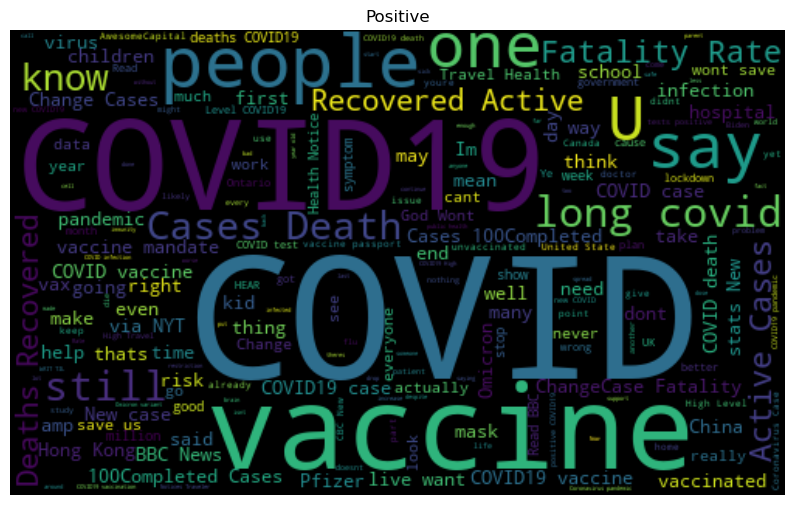

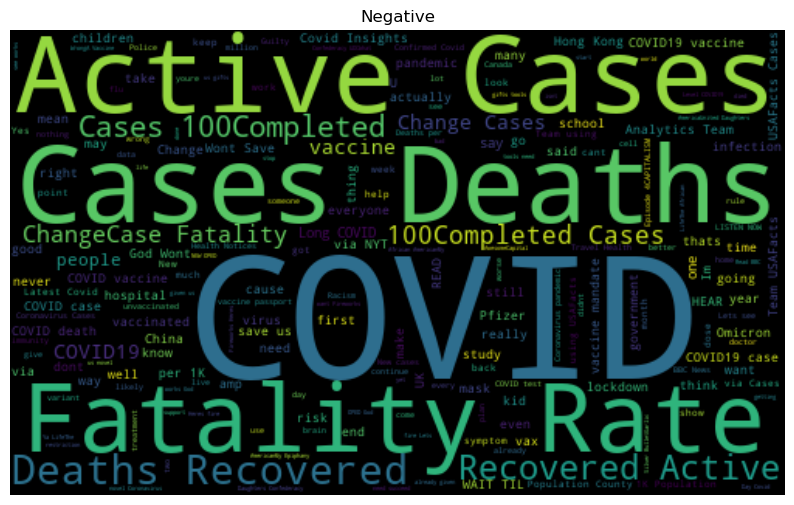

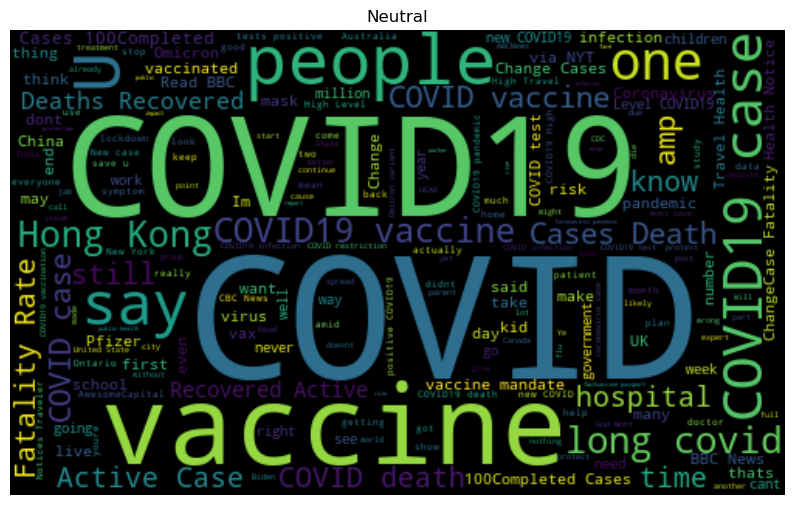

<Figure size 1000x800 with 0 Axes>

In [29]:
plt.figure(figsize = (10,8))
# Creating wordclouds for positive, negative, neutral tweets
cloud_of_Words(positive_tweet, 'Positive')
cloud_of_Words(negative_tweet, 'Negative')
cloud_of_Words(neutral_tweet, 'Neutral')

### Bar Chart

28433
28216
17904


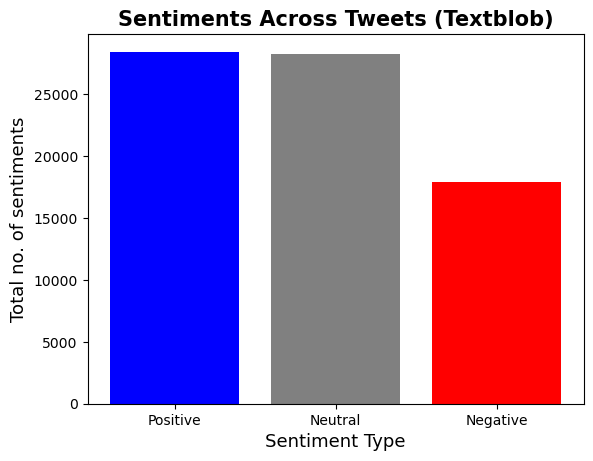

In [30]:
plt.title('Sentiments Across Tweets (Textblob)',fontsize = 15, fontweight = 'bold')

pos_total = data[data['Textblob'] == 'Positive']['Textblob'].count()
neu_total = data[data['Textblob'] == 'Neutral']['Textblob'].count()
neg_total = data[data['Textblob'] == 'Negative']['Textblob'].count()
print(pos_total)
print(neu_total)
print(neg_total)

sentiment_type = ['Positive','Neutral','Negative']
sentiment_total = [pos_total, neu_total, neg_total]

plt.bar(sentiment_type, sentiment_total, color = ['blue', 'grey', 'red'])
plt.ylabel('Total no. of sentiments',fontsize=13)
plt.xlabel('Sentiment Type',fontsize=13)
plt.show()

### <font color=#FF0000>**Sentiment Analysis (Using Sentiment Intensity Analyzer)**</font> <br>

A class in the nltk (Natural Language Toolkit) library of Python that is used for sentiment analysis of text data. Specifically, it is a rule-based sentiment analysis tool that uses a lexicon of words and their associated sentiment scores to compute the overall sentiment of a piece of text.

The SentimentIntensityAnalyzer() class has a polarity_scores() method that takes a string of text as input and returns a dictionary containing the sentiment scores for that text. 

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = data.clean_data.apply(ps)
sentiment_scores

0        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2        {'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...
3        {'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...
4        {'neg': 0.226, 'neu': 0.528, 'pos': 0.245, 'co...
                               ...                        
86088    {'neg': 0.42, 'neu': 0.58, 'pos': 0.0, 'compou...
86089    {'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...
86090    {'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'comp...
86091    {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...
86092    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: clean_data, Length: 80241, dtype: object

In [33]:
sentiment_df = pd.DataFrame(data = list(sentiment_scores))
sentiment_df.head()

neg    neu    pos  compound
0  0.000  1.000  0.000    0.0000
1  0.000  1.000  0.000    0.0000
2  0.000  0.732  0.268    0.5106
3  0.000  0.732  0.268    0.5106
4  0.226  0.528  0.245   -0.1280

We can see that there is neg for negative sentiment, neu for neutral sentiment, pos for positive sentiment, and compound as the average rate of the sentiment. We will focused on the compound.

For negative sentiment, the compound score will be closer to -1, and the opposite goes for the positive sentiment, which will be closer to 1. Neutral sentiment will be a 0.

For our analysis, we will create another column called label, where we will be labelling the scores based on the compound polarity value

In [34]:
labelize = lambda x : 'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['Vader'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

neg    neu    pos  compound     Vader
0  0.000  1.000  0.000    0.0000   neutral
1  0.000  1.000  0.000    0.0000   neutral
2  0.000  0.732  0.268    0.5106  positive
3  0.000  0.732  0.268    0.5106  positive
4  0.226  0.528  0.245   -0.1280  negative

In [35]:
filtered_label = data.join(sentiment_df.Vader)
filtered_label.head()

datetime             tweet_id  \
0  2022-03-30 23:59:43+00:00  1509319493717213185   
1  2022-03-30 23:59:18+00:00  1509319387941113856   
2  2022-03-30 23:57:25+00:00  1509318912940261381   
3  2022-03-30 23:56:36+00:00  1509318706509213699   
4  2022-03-30 23:52:42+00:00  1509317728632393729   

                                                text        username  \
0  @cryptotosis @SputnikNetwork @cryptotosis 5sta...  TheWadSquad_io   
1                     @Eon_Reel @POTUS COVID is real   sharonlafon91   
2  Staff COVID-19 cases continue to stymie small-...         JDignum   
3  Staff COVID-19 cases continue to stymie small-...         JDignum   
4  COVID elbows Jets in face - Winnipeg Free Pres...         JDignum   

                                                 url  \
0  https://twitter.com/TheWadSquad_io/status/1509...   
1  https://twitter.com/sharonlafon91/status/15093...   
2  https://twitter.com/JDignum/status/15093189129...   
3  https://twitter.com/JDignum/status/15093187065...   
4  https://twitter.com/JDignum/status/15093177286...   

               user_location  like_count  retweet_count  follower_count  \
0                   Stargaze           1              0            3062   
1                        NaN           3              0             107   
2  Hellberta🔥via Twitterstan           0              0            2478   
3  Hellberta🔥via Twitterstan           0              0            2478   
4  Hellberta🔥via Twitterstan           0              0            2478   

   reply_count  verified     hashtags  \
0            1     False  ['sputnik']   
1            3     False          NaN   
2            0     False          NaN   
3            0     False          NaN   
4            0     False          NaN   

                                          clean_data  \
0                                             5stars   
1                                         COVID real   
2  Staff COVID19 cases continue stymie smallbusin...   
3  Staff COVID19 cases continue stymie smallbusin...   
4  COVID elbows Jets face Winnipeg Free Press COV...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...       0.0           0.0   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...       0.2           0.3   
2  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
3  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
4  {'polarity': 0.19999999999999998, 'subjectivit...       0.2           0.5   

   Textblob     Vader  
0   Neutral   neutral  
1  Positive   neutral  
2  Positive  positive  
3  Positive  positive  
4  Positive  negative

### Word Cloud

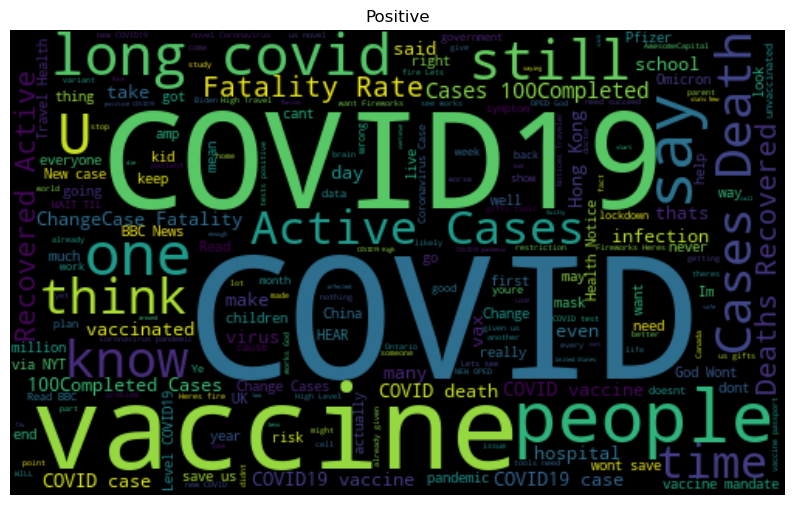

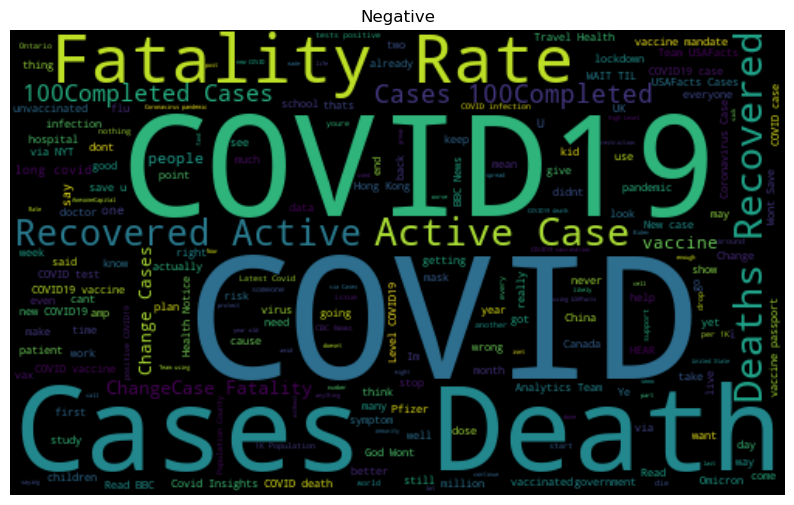

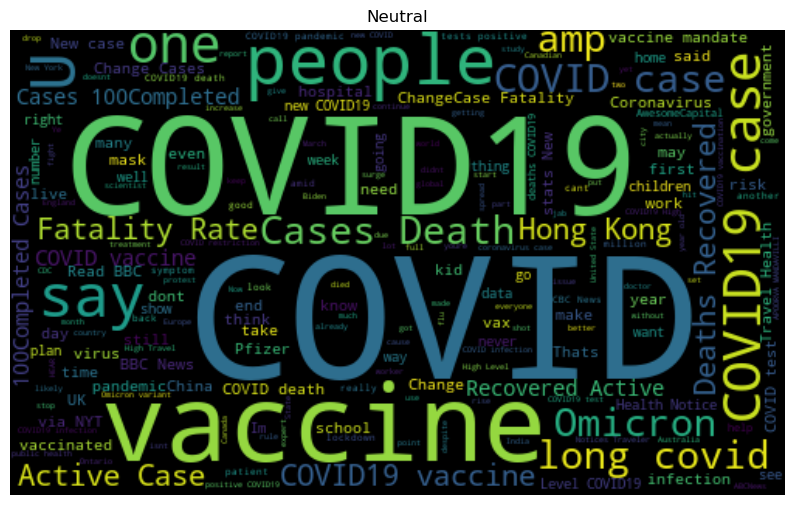

<Figure size 1000x800 with 0 Axes>

In [36]:
# categorized tweets in seperate Series
positive_tweet =  filtered_label[filtered_label['Vader'] == 'positive']['clean_data']
negative_tweet =  filtered_label[filtered_label['Vader'] == 'negative']['clean_data']
neutral_tweet = filtered_label[filtered_label['Vader'] == 'neutral']['clean_data']

# Function for creating WordClouds
def cloud_of_Words(tweets,title):
    forcloud = ' '.join([tweet for tweet in tweets])
    wordcloud = WordCloud(width =500,height = 300,random_state =5,max_font_size=110).generate(forcloud)
    plt.imshow(wordcloud, interpolation ='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.figure(figsize = (10,8))
    
plt.figure(figsize = (10,8))
# Creating wordclouds for positive, negative, neutral tweets
cloud_of_Words(positive_tweet, 'Positive')
cloud_of_Words(negative_tweet, 'Negative')
cloud_of_Words(neutral_tweet, 'Neutral')

### Bar Chart

22747
23395
28411


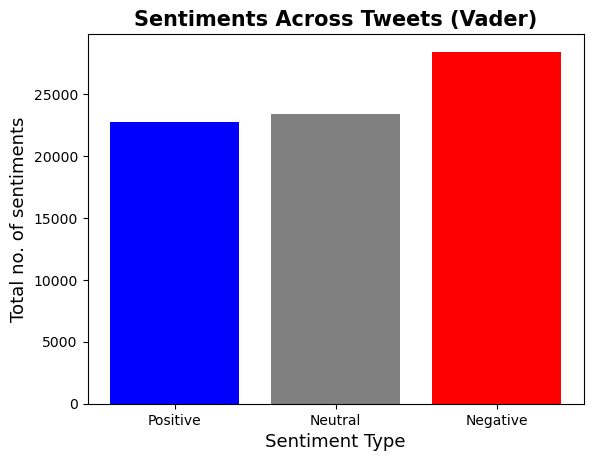

In [37]:
plt.title('Sentiments Across Tweets (Vader)',fontsize = 15, fontweight = 'bold')

pos_total = filtered_label[filtered_label['Vader'] == 'positive']['Vader'].count()
neu_total = filtered_label[filtered_label['Vader'] == 'neutral']['Vader'].count()
neg_total = filtered_label[filtered_label['Vader'] == 'negative']['Vader'].count()
print(pos_total)
print(neu_total)
print(neg_total)

sentiment_type = ['Positive','Neutral','Negative']
sentiment_total = [pos_total, neu_total, neg_total]

plt.bar(sentiment_type, sentiment_total, color = ['blue', 'grey', 'red'])
plt.ylabel('Total no. of sentiments',fontsize=13)
plt.xlabel('Sentiment Type',fontsize=13)
plt.show()

### Time Series (Vader)

In [38]:
filtered_label['datetime'] = pd.to_datetime(filtered_label.datetime).dt.date
filtered_label['datetime']

0        2022-03-30
1        2022-03-30
2        2022-03-30
3        2022-03-30
4        2022-03-30
            ...    
86088    2022-01-01
86089    2022-01-01
86090    2022-01-01
86091    2022-01-01
86092    2022-01-01
Name: datetime, Length: 80241, dtype: object

In [39]:
filtered_label.head()

datetime             tweet_id  \
0  2022-03-30  1509319493717213185   
1  2022-03-30  1509319387941113856   
2  2022-03-30  1509318912940261381   
3  2022-03-30  1509318706509213699   
4  2022-03-30  1509317728632393729   

                                                text        username  \
0  @cryptotosis @SputnikNetwork @cryptotosis 5sta...  TheWadSquad_io   
1                     @Eon_Reel @POTUS COVID is real   sharonlafon91   
2  Staff COVID-19 cases continue to stymie small-...         JDignum   
3  Staff COVID-19 cases continue to stymie small-...         JDignum   
4  COVID elbows Jets in face - Winnipeg Free Pres...         JDignum   

                                                 url  \
0  https://twitter.com/TheWadSquad_io/status/1509...   
1  https://twitter.com/sharonlafon91/status/15093...   
2  https://twitter.com/JDignum/status/15093189129...   
3  https://twitter.com/JDignum/status/15093187065...   
4  https://twitter.com/JDignum/status/15093177286...   

               user_location  like_count  retweet_count  follower_count  \
0                   Stargaze           1              0            3062   
1                        NaN           3              0             107   
2  Hellberta🔥via Twitterstan           0              0            2478   
3  Hellberta🔥via Twitterstan           0              0            2478   
4  Hellberta🔥via Twitterstan           0              0            2478   

   reply_count  verified     hashtags  \
0            1     False  ['sputnik']   
1            3     False          NaN   
2            0     False          NaN   
3            0     False          NaN   
4            0     False          NaN   

                                          clean_data  \
0                                             5stars   
1                                         COVID real   
2  Staff COVID19 cases continue stymie smallbusin...   
3  Staff COVID19 cases continue stymie smallbusin...   
4  COVID elbows Jets face Winnipeg Free Press COV...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...       0.0           0.0   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...       0.2           0.3   
2  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
3  {'polarity': 0.4, 'subjectivity': 0.8, 'sentim...       0.4           0.8   
4  {'polarity': 0.19999999999999998, 'subjectivit...       0.2           0.5   

   Textblob     Vader  
0   Neutral   neutral  
1  Positive   neutral  
2  Positive  positive  
3  Positive  positive  
4  Positive  negative

In [40]:
data_vader = filtered_label[['username', 'datetime', 'Vader']].groupby(['datetime', 'Vader']).count().reset_index()
data_vader.columns = ['date', 'Vader', 'counts']
data_vader.head()

date     Vader  counts
0  2022-01-01  negative     231
1  2022-01-01   neutral     197
2  2022-01-01  positive     189
3  2022-01-02  negative     252
4  2022-01-02   neutral     228

In [41]:
px.line(data_vader, x='date', y='counts', color='Vader', color_discrete_sequence=['red', 'grey', 'blue'], title='COVID-19 Vaccines Sentiment Analysis (Vader)')

### Time Series (Textblob)

In [42]:
data_Textblob = filtered_label[['username', 'datetime', 'Textblob']].groupby(['datetime', 'Textblob']).count().reset_index()
data_Textblob.columns = ['date', 'Textblob', 'counts']
data_Textblob.head()

date  Textblob  counts
0  2022-01-01  Negative     132
1  2022-01-01   Neutral     258
2  2022-01-01  Positive     227
3  2022-01-02  Negative     138
4  2022-01-02   Neutral     225

In [43]:
px.line(data_Textblob, x='date', y='counts', color='Textblob', color_discrete_sequence=['red', 'grey', 'blue'], title='COVID-19 Vaccines Sentiment Analysis (Textblob)')